# Clustering-Bisecting K-Means

### Import necessary libraries and initialize SparkSession

In [9]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from pyspark.ml.linalg import Vectors

# Initialize SparkSession
spark = SparkSession.builder.appName("BisectingKMeans_Clustering").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

### Generate sample data

In [10]:
# Generate sample data
n_samples = 1000
random_state = 0
X, _ = make_blobs(n_samples=n_samples, centers=2, random_state=random_state)

# Create a DataFrame with a single column "features"
df = spark.createDataFrame([(Vectors.dense(x.tolist()),) for x in X], ["features"])

### Feature Engineering, fit the model and evaluate the clustering

In [11]:
# Perform Bisecting K-Means clustering
assembler = VectorAssembler(inputCols=["features"], outputCol="features_vec")
df = assembler.transform(df)

bkm = BisectingKMeans().setK(2).setSeed(1)
model = bkm.fit(df)
transformed_data = model.transform(df)

# Evaluate clustering using Silhouette score
evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(transformed_data)
print(f"Silhouette Score: {silhouette_score:.4f}")


Silhouette Score: 0.7466


### Visualize the clusters

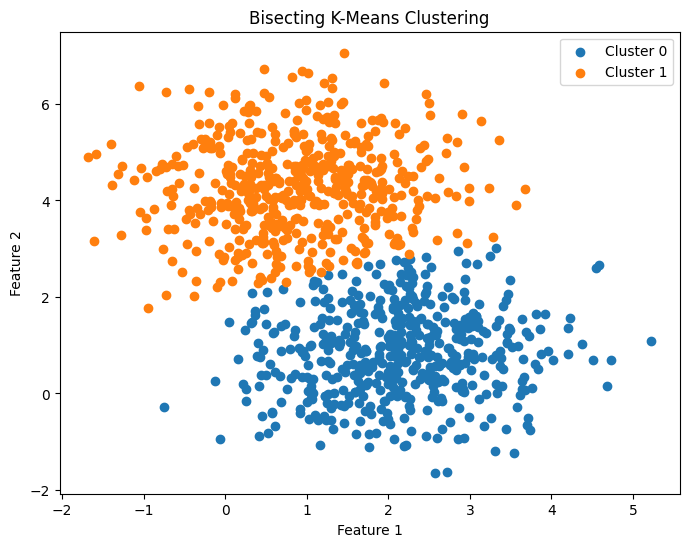

In [12]:
# Visualize the clusters
plt.figure(figsize=(8, 6))
for cluster_id in np.unique(transformed_data.select("prediction").collect()):
    cluster_id = int(cluster_id)  # Convert cluster_id to Python integer
    cluster_data = transformed_data.filter(transformed_data["prediction"] == cluster_id).select("features").collect()
    cluster_points = [point["features"][0] for point in cluster_data]
    cluster_points_y = [point["features"][1] for point in cluster_data]
    plt.scatter(cluster_points, cluster_points_y, label=f"Cluster {cluster_id}")

plt.title("Bisecting K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()